In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.mnist
import models.resnet
import models.resnet_dropout
from torchensemble import VotingClassifier

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., min=.1, max=1.):
        self.std = std
        self.mean = mean
        self.min = min
        self.max = max
        
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean, self.min, self.max)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
transforms_train = torchvision.transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

transforms_test = torchvision.transforms.Compose(
    [
        # transforms.RandomRotation(degrees=(25, 25)),
        # transforms.ColorJitter(brightness=.5, saturation=1, contrast=1),

        transforms.ToTensor(),
        # AddGaussianNoise(mean=0, std=.10),

        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

data_train = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=True, transform=transforms_train)
data_train, data_val = torch.utils.data.random_split(data_train, [45000, 5000], generator=torch.Generator().manual_seed(0))

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=64,
                                                shuffle=True,
                                                )
data_loader_val = torch.utils.data.DataLoader(data_val,
                                                batch_size=64,
                                                shuffle=False,
                                                )

data_test = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=False, transform=transforms_test)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=64,
                                               shuffle=False)

data_test_unnormalized = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=False, transform= torchvision.transforms.Compose(
    [
        # transforms.RandomRotation(degrees=(25, 25)),
        transforms.ColorJitter(brightness=.5, saturation=1, contrast=1),

        transforms.ToTensor(),
        # AddGaussianNoise(mean=0, std=.10),

        # transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ]))

dataset_sizes = {"train": len(data_train), "val": len(data_val), "test": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_val, "test": data_loader_test}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


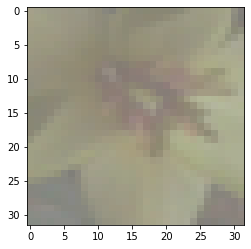

In [7]:
plt.imshow(data_test_unnormalized[5][0].swapaxes(0,2))

In [17]:
from torchensemble.utils import io
model = models.resnet.ResNet18(
    num_classes=100).to(device)
ensemble = VotingClassifier(estimator=model, n_estimators=5)
io.load(ensemble) 

In [26]:
# model = torch.load("checkpoints/cifar100_resnet18.pt", map_location=device)
# model_dropout = torch.load("checkpoints/cifar100_resnet18_dropout.pt", map_location=device)

model = torch.load("checkpoints/cifar100_resnet18.pt")
model_dropout = torch.load("checkpoints/cifar100_resnet18_dropout0.1.pt")
model_dropout.load_state_dict(model.state_dict())
model = model_dropout
# utils.mc_dropout.set_dropout_p(model, model, .03)
model.dropout = torch.nn.Dropout(p=0)

model_dropout = torch.load("checkpoints/cifar100_resnet18_dropout0.1.pt")
model_dropout.dropout = torch.nn.Dropout(p=0)

model_finetuned = model
model = torch.load("checkpoints/cifar100_resnet18.pt")

# model_dropout = torch.load("models/cifar100_resnet18_0.2dropout_all")
# utils.mc_dropout.set_dropout_p(model_dropout, model_dropout, .15)
# model_dropout.dropout = torch.nn.Dropout(p=0)

In [41]:
model = torch.load("checkpoints/cifar100_mobilenetv2.pt")
model_dropout = torch.load("checkpoints/cifar100_mobilenetv2_dropout0.1.pt")
model_dropout.load_state_dict(model.state_dict())
model = model_dropout
# utils.mc_dropout.set_dropout_p(model, model, .03)
model.dropout = torch.nn.Dropout(p=0)

model_dropout = torch.load("checkpoints/cifar100_mobilenetv2_dropout0.1.pt")
model_dropout.dropout = torch.nn.Dropout(p=0)

model_finetuned = model
model = torch.load("checkpoints/cifar100_mobilenetv2.pt")

In [42]:
model_dropout

MobileNetV2Dropout(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidualDropout(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout2d(p=0.1, inplace=False)
      )
    )
    (2): InvertedResidualDropout(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [35]:
model.classifier[0] = nn.Dropout(p=0.5)

In [45]:
def add_dropout(model, block, prob, omitted_blocks=[]):

    for name, p in block.named_children():
        if any(map(lambda x: isinstance(p, x), omitted_blocks)):
            continue
        if isinstance(p, torch.nn.Module) or isinstance(p, torch.nn.Sequential):
            add_dropout(model, p, prob, omitted_blocks)

        if isinstance(p, torch.nn.ReLU6):
            setattr(block, name, torch.nn.Sequential(torch.nn.ReLU6(), torch.nn.Dropout2d(p=prob)))
            # return model
add_dropout(model, model, 0.05)

model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sequential(
        (0): ReLU6()
        (1): Dropout2d(p=0.05, inplace=False)
      )
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Sequential(
            (0): ReLU6()
            (1): Dropout2d(p=0.05, inplace=False)
          )
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNRe

In [28]:
utils.mc_dropout.set_dropout_p(model_dropout, model_dropout, 0.1)

ResNetDropout(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [34]:
# model = models.resnet_dropout.ResNet18Dropout(num_classes=100).to(device)
print(model)
optimizer = torch.optim.Adam(model_finetuned.parameters())
criterion = nn.CrossEntropyLoss()
train_progress = utils.model.train_model(
    model_finetuned, 10, optimizer, criterion, data_loaders, device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

train Loss: 1.77 Acc: 0.51 Avg. conf: 0.64 Avg. max. prob: 0.53: 100%|██████████| 704/704 [00:43<00:00, 16.25it/s]
val Loss: 1.59 Acc: 0.56 Avg. conf: 0.70 Avg. max. prob: 0.60: 100%|██████████| 79/79 [00:02<00:00, 32.92it/s]

Epoch 2/10
----------



train Loss: 1.62 Acc: 0.54 Avg. conf: 0.65 Avg. max. prob: 0.54: 100%|██████████| 704/704 [00:43<00:00, 16.11it/s]
val Loss: 1.59 Acc: 0.56 Avg. conf: 0.71 Avg. max. prob: 0.60: 100%|██████████| 79/79 [00:02<00:00, 31.13it/s]

Epoch 3/10
----------



train Loss: 1.58 Acc: 0.55 Avg. conf: 0.66 Avg. max. prob: 0.55: 100%|██████████| 704/704 [00:43<00:00, 16.00it/s]
val Loss: 1.56 Acc: 0.57 Avg. conf: 0.71 Avg. max. prob: 0.61: 100%|██████████| 79/79 [00:02<00:00, 31.06it/s]

Epoch 4/10
----------



train Loss: 1.54 Acc: 0.56 Avg. conf: 0.67 Avg. max. prob: 0.56: 100%|██████████| 704/704 [00:44<00:00, 15.77it/s]
val Loss: 1.57 Acc: 0.57 Avg. conf: 0.72 Avg. max. prob: 0.62: 100%|██████████| 79/79 [00:02<00:00, 30.19it/s]

Epoch 5/10
----------



train Loss: 1.52 Acc: 0.56 Avg. conf: 0.67 Avg. max. prob: 0.57: 100%|██████████| 704/704 [00:44<00:00, 15.79it/s]
val Loss: 1.56 Acc: 0.58 Avg. conf: 0.73 Avg. max. prob: 0.63: 100%|██████████| 79/79 [00:02<00:00, 31.92it/s]

Epoch 6/10
----------



train Loss: 1.50 Acc: 0.57 Avg. conf: 0.68 Avg. max. prob: 0.57: 100%|██████████| 704/704 [00:44<00:00, 15.78it/s]
val Loss: 1.53 Acc: 0.57 Avg. conf: 0.73 Avg. max. prob: 0.63: 100%|██████████| 79/79 [00:02<00:00, 31.90it/s]

Epoch 7/10
----------



train Loss: 1.48 Acc: 0.57 Avg. conf: 0.68 Avg. max. prob: 0.57: 100%|██████████| 704/704 [00:43<00:00, 16.14it/s]
val Loss: 1.53 Acc: 0.57 Avg. conf: 0.73 Avg. max. prob: 0.63: 100%|██████████| 79/79 [00:02<00:00, 30.80it/s]

Epoch 8/10
----------



train Loss: 1.46 Acc: 0.58 Avg. conf: 0.68 Avg. max. prob: 0.58: 100%|██████████| 704/704 [00:44<00:00, 15.73it/s]
val Loss: 1.53 Acc: 0.58 Avg. conf: 0.73 Avg. max. prob: 0.63: 100%|██████████| 79/79 [00:02<00:00, 30.95it/s]

Epoch 9/10
----------



train Loss: 1.46 Acc: 0.57 Avg. conf: 0.69 Avg. max. prob: 0.58: 100%|██████████| 704/704 [00:44<00:00, 15.87it/s]
val Loss: 1.51 Acc: 0.59 Avg. conf: 0.73 Avg. max. prob: 0.64: 100%|██████████| 79/79 [00:02<00:00, 29.89it/s]

Epoch 10/10
----------



train Loss: 1.43 Acc: 0.58 Avg. conf: 0.69 Avg. max. prob: 0.59: 100%|██████████| 704/704 [00:44<00:00, 15.74it/s]
val Loss: 1.52 Acc: 0.58 Avg. conf: 0.73 Avg. max. prob: 0.63: 100%|██████████| 79/79 [00:02<00:00, 31.21it/s]


In [35]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model, device)
scaled_model.set_temperature(data_loader_val)

# scaled_model_dropout = ModelWithTemperature(model_dropout, device)
# scaled_model_dropout.set_temperature(data_loader_val)

Before temperature - NLL: 1.577, ECE: 0.084
Optimal temperature: 1.389
After temperature - NLL: 1.509, ECE: 0.027


ModelWithTemperature(
  (model): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bi

In [36]:

# progress_ensemble = utils.model.run_validation(
#     ensemble, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=0)
progress_model = utils.model.run_validation(
    model, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=20)
progress_model_finetuned = utils.model.run_validation(
    model_finetuned, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=20)
progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=20)
progress_scaled_model = utils.model.run_validation(
    scaled_model, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=0)
# progress_scaled_model_dropout = utils.model.run_validation(
#     scaled_model_dropout, data_loaders["test"], utils.metrics.Progress(), device, mc_dropout_iters=20)

Avg. acc.: 59.32: 100%|██████████| 157/157 [00:03<00:00, 44.92it/s]


In [22]:
import pickle
with open("cifar100/cifar-100-python/meta", "rb") as f:
    meta = pickle.load(f)

In [40]:
class_names = list(meta.values())[0]

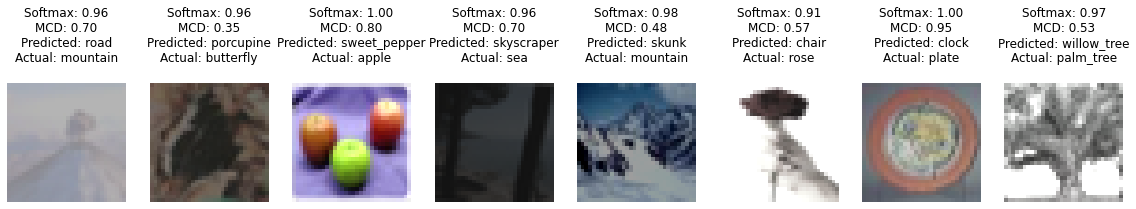

In [54]:
incorrect = np.argwhere((progress_model.predictions != progress_model.labels) & (progress_model.max_probs > .9)).ravel()
# idx = np.argsort(progress_model.max_probs)[::-1][incorrect]
idx=incorrect
num = 8
fig, axs = plt.subplots(1, num, figsize=(20,10))
dropout_max_probs_untrained = progress_model.dropout_outputs.max(axis=-1)

for i in range(num):
    axs[i].imshow(data_test_unnormalized[idx[i]][0].permute(1,2,0), cmap="Greys")
    axs[i].set_title(
        f"Softmax: {progress_model.max_probs[idx[i]]:.2f}\n"
        f"MCD: {dropout_max_probs_untrained[idx[i]]:.2f}\n"
        f"Predicted: {class_names[int(progress_model.predictions[idx[i]])]}\n"
        f"Actual: {class_names[int(progress_model.labels[idx[i]])]}\n"
    )
    axs[i].axis("off")


# progress_model.max_probs[ids]


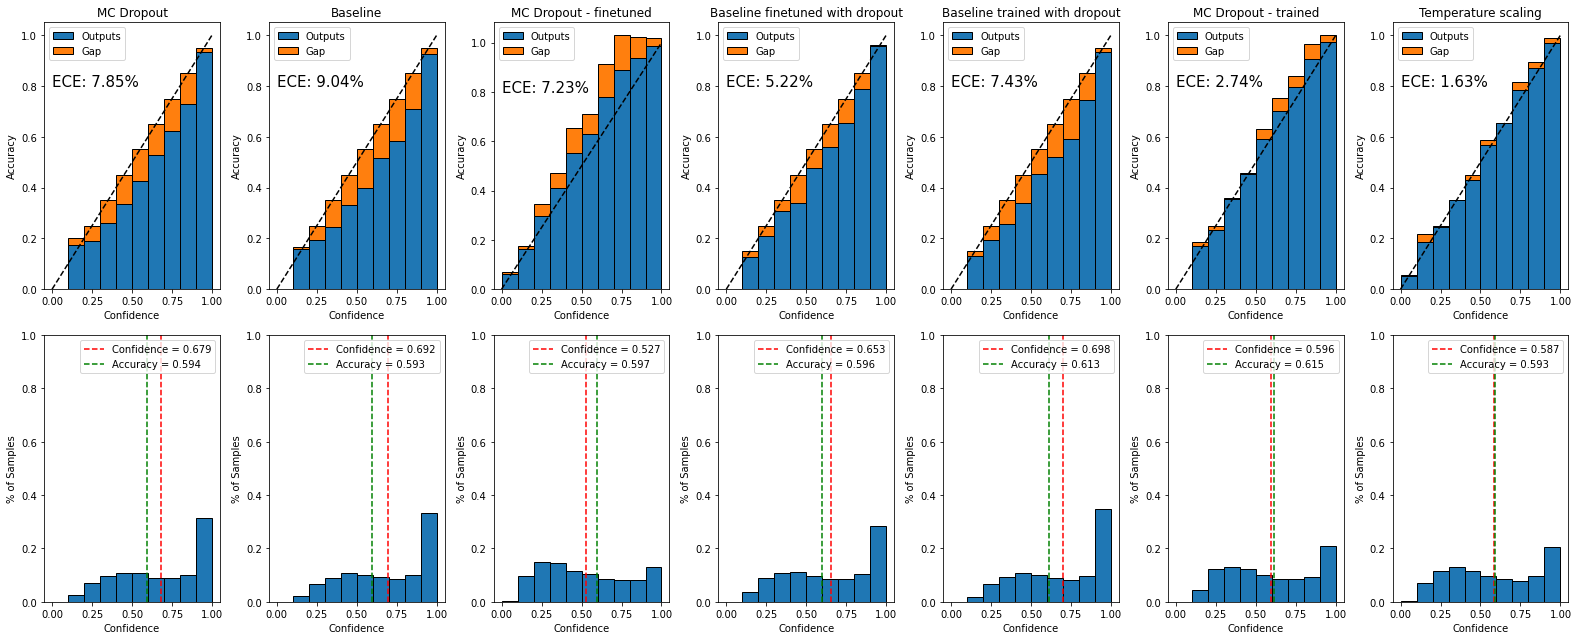

In [37]:
dropout_finetuned_max_probs = progress_model_finetuned.dropout_outputs.max(axis=-1)
dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
# dropout_scaled_max_probs = progress_scaled_model_dropout.dropout_outputs.max(axis=-1)


# ensemble_max_probs = progress_ensemble.logits.max(axis=1)
utils.visualisations.calibration_graph([
        # ("Ensemble", ensemble_max_probs, np.argsort(ensemble_max_probs), progress_ensemble.predictions),
        ("MC Dropout", dropout_max_probs, np.argsort(dropout_max_probs), progress_model.dropout_predictions),
        ("Baseline", progress_model.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
        ("MC Dropout - finetuned", dropout_finetuned_max_probs, np.argsort(dropout_finetuned_max_probs), progress_model_finetuned.dropout_predictions),
        ("Baseline finetuned with dropout", progress_model_finetuned.max_probs, np.argsort(progress_model_finetuned.max_probs), progress_model_finetuned.predictions),
        ("Baseline trained with dropout", progress_model_dropout.max_probs, np.argsort(progress_model.max_probs), progress_model_dropout.predictions),
        ("MC Dropout - trained", trained_dropout_max_probs, np.argsort(trained_dropout_max_probs), progress_model_dropout.dropout_predictions),
        ("Temperature scaling", progress_scaled_model.max_probs, np.argsort(progress_scaled_model.max_probs), progress_scaled_model.predictions),
        # ("Dropout with temperature", progress_scaled_model_dropout.max_probs, np.argsort(progress_scaled_model_dropout.max_probs), progress_scaled_model_dropout.predictions),    
        # ("MCD with temperature", dropout_scaled_max_probs, np.argsort(dropout_scaled_max_probs), progress_scaled_model.dropout_predictions),
    ],
    progress_model.labels,
    )

In [18]:
y_true = nn.functional.one_hot(torch.tensor(progress_model.labels.astype("long")))

print("Brier score")
print("Ensemble: " + str(utils.metrics.compute_brier_score_avg(progress_ensemble.logits, y_true)))
print("MC Dropout: " + str(utils.metrics.compute_brier_score_avg(progress_model.dropout_outputs, y_true)))
print("Baseline: " + str(utils.metrics.compute_brier_score_avg(progress_model.probs, y_true)))
print("Baseline trained with dropout: " + str(utils.metrics.compute_brier_score_avg(progress_model_dropout.probs, y_true)))
print("MC Dropout - trained: " + str(utils.metrics.compute_brier_score_avg(progress_model_dropout.dropout_outputs, y_true)))
print("Temperature scaling: " + str(utils.metrics.compute_brier_score_avg(progress_scaled_model.probs, y_true)))

Brier score
Ensemble: 0.003734451324129658
MC Dropout: 0.004741831274326375
Baseline: 0.00553298274156638
Baseline trained with dropout: 0.005241850545741098
MC Dropout - trained: 0.0047262803315466844
Temperature scaling: 0.004930029249480763


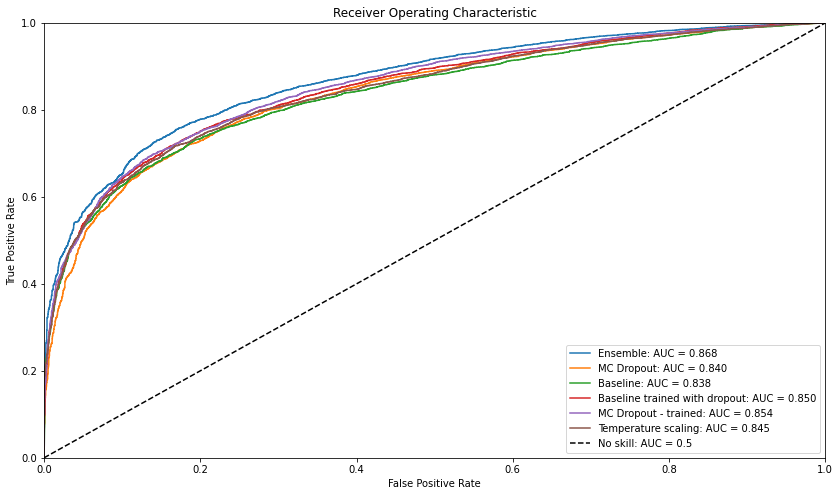

In [19]:
curves = []


correct = progress_ensemble.predictions == progress_ensemble.labels
max_probs = progress_ensemble.logits.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Ensemble"))

correct = progress_model.dropout_predictions == progress_model.labels
max_probs = progress_model.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout"))

correct = progress_model.predictions == progress_model.labels
max_probs = progress_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline"))

correct = progress_model_dropout.predictions == progress_model.labels
max_probs = progress_model_dropout.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline trained with dropout"))

correct = progress_model_dropout.dropout_predictions == progress_model.labels
max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout - trained"))

correct = progress_scaled_model.predictions == progress_scaled_model.labels
max_probs = progress_scaled_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Temperature scaling"))



plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

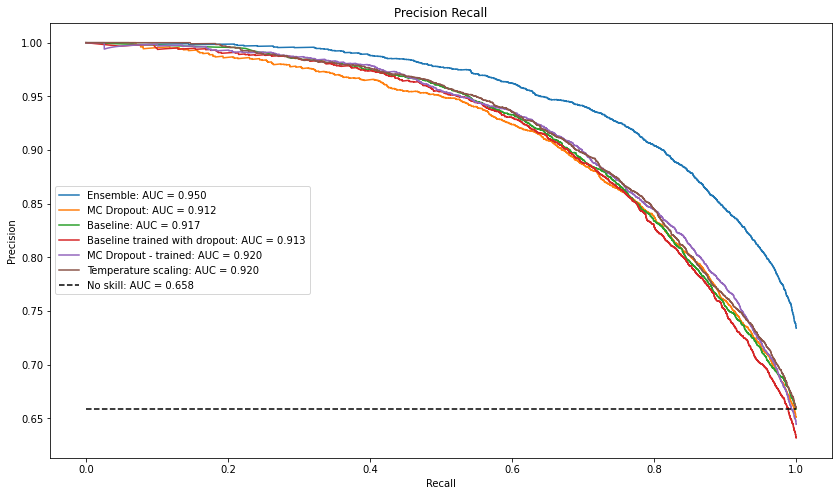

In [20]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k", linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [21]:
curves = {
    "ensemble": utils.metrics.model_metrics(),
    "mcd": utils.metrics.model_metrics(),
    "baseline": utils.metrics.model_metrics(),
    "baseline_dropout": utils.metrics.model_metrics(),
    "mcd_trained":utils.metrics.model_metrics(),
    "temp_scaling":utils.metrics.model_metrics()
}




for s in np.arange(0, 1.1, 0.1):
    transforms_test = torchvision.transforms.Compose(
        [
            # transforms.RandomRotation(degrees=(s,s)),
            transforms.ColorJitter(brightness=s/2, saturation=s, contrast=s),
            transforms.ToTensor(),
            # AddGaussianNoise(mean=0, std=s),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

    data_test = torchvision.datasets.CIFAR100(
        "cifar100", download=True, train=False, transform=transforms_test)
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                                batch_size=64,
                                                shuffle=False)
    

    print(f"Strength: {s}")
    progress_ensemble = utils.model.run_validation(
        ensemble, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)
    progress_model = utils.model.run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=5)
    progress_model_dropout = utils.model.run_validation(
        model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=5)
    progress_scaled_model = utils.model.run_validation(
        scaled_model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)


    # dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
    # trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)

    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress_model.labels


    max_probs = progress_ensemble.logits.max(axis=1)
    utils.metrics.update_model_metrics(progress_ensemble, progress_ensemble.logits, max_probs, progress_ensemble.predictions, labels, bins, curves["ensemble"], s)

    max_probs = progress_model.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model, progress_model.dropout_outputs, max_probs, progress_model.dropout_predictions, labels, bins, curves["mcd"], s)
    
    max_probs = progress_model.max_probs
    utils.metrics.update_model_metrics(progress_model, progress_model.probs, max_probs, progress_model.predictions, labels, bins, curves["baseline"], s)

    max_probs = progress_model_dropout.max_probs
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.probs, max_probs, progress_model_dropout.predictions, labels, bins, curves["baseline_dropout"], s)

    max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.dropout_outputs, max_probs, progress_model_dropout.dropout_predictions, labels, bins, curves["mcd_trained"], s)

    max_probs = progress_scaled_model.max_probs
    utils.metrics.update_model_metrics(progress_scaled_model, progress_scaled_model.probs, max_probs, progress_scaled_model.predictions, labels, bins, curves["temp_scaling"], s)
    


Files already downloaded and verified
Strength: 0.0


Avg. acc.: 65.84: 100%|██████████| 157/157 [00:03<00:00, 46.03it/s]


Files already downloaded and verified
Strength: 0.1


Avg. acc.: 65.65:  36%|███▌      | 56/157 [00:04<00:08, 12.60it/s]


KeyboardInterrupt: 

In [269]:
import pickle
with open( "color_jitter_cifar100.pickle", "wb") as f:
    pickle.dump(curves,f)

In [1]:
import pickle
with open( "experiments/rotation_cifar100.pickle", "rb") as f:
    curves = pickle.load(f)

AttributeError: Can't get attribute 'model_metrics' on <module '__main__'>

In [43]:
curves

{'ensemble': <__main__.model_metrics at 0x7fc3f17fc8e0>,
 'mcd': <__main__.model_metrics at 0x7fc3f1532e50>,
 'baseline': <__main__.model_metrics at 0x7fc3f15327c0>,
 'baseline_dropout': <__main__.model_metrics at 0x7fc3f17ede20>,
 'mcd_trained': <__main__.model_metrics at 0x7fc3f110f610>,
 'temp_scaling': <__main__.model_metrics at 0x7fc3f110f340>}

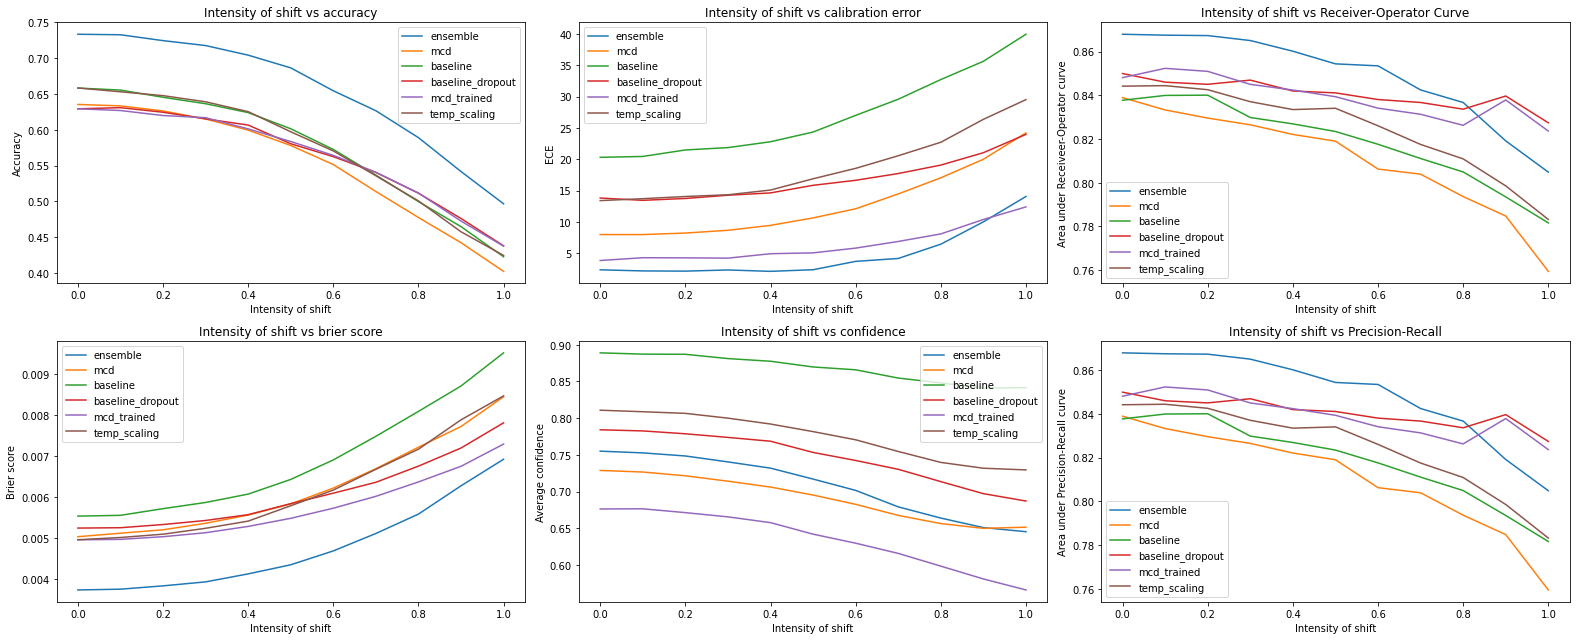

In [270]:
fig, axs = plt.subplots(2, 3, figsize=(22, 9))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    ax = axs[1][0]
    ax.plot(m.strengths, m.brier, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs brier score")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs calibration error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.confs, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs confidence")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][2]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs Receiver-Operator Curve")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiveer-Operator curve")

    ax = axs[1][2]
    ax.plot(m.strengths, m.aupr, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs Precision-Recall")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")
fig.tight_layout()